In [30]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from statsmodels.stats.power import TTestPower
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

# Quiz 2 - Get Hyp'

<ul>
<li> Use this as a starting point for your work, but answer the questions on Moodle. 
<li> Publish this to your GitHub and submit the link in the question on Moodle. 
</ul>

## Potentially Useful Information

#### Data Dictionary
<ul>
<li>credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
<li>purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
<li>int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
<li>installment: The monthly installments owed by the borrower if the loan is funded.
<li>log.annual.inc: The natural log of the self-reported annual income of the borrower.
<li>dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
<li>fico: The FICO credit score of the borrower.
<li>days.with.cr.line: The number of days the borrower has had a credit line.
<li>revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
<li>revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
<li>inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
<li>not.fully.paid: 1 if the borrower failed to repay their loan, 0 if they have not failed
</ul>

#### FICO Score Groups

![FICO](fico_range.png "FICO Ranges")

#### Note on ANOVA - Might be Useful, Might Not

> @JeremyMiles is right. First, there's a rule of thumb that the ANOVA is robust to heterogeneity of variance so long as the largest variance is not more than 4 times the smallest variance. Furthermore, the general effect of heterogeneity of variance is to make the ANOVA less efficient. That is, you would have lower power. Since you have a significant effect anyway, there is less reason to be concerned here. 
- https://stats.stackexchange.com/questions/56971/alternative-to-one-way-anova-unequal-variance

In [41]:
# Please don't alter this part. 
df = pd.read_csv("loan_data.csv")
df.drop(columns={"delinq.2yrs", "pub.rec"}, inplace=True)
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,0


### Visualize/Explore Data - If You Want, You Do You

## Solutions

In [13]:
df[["fico","not.fully.paid"]].sample(10)

,fico,not.fully.paid
7984,652,0
5577,712,0
1551,717,0
327,757,0
4973,677,0
7850,647,1
207,702,1
7091,727,0
2847,662,0
2337,672,1


In [54]:
dfPaid = df[df["not.fully.paid"] == 0]
dfPaid = dfPaid["fico"]
dfUnpaid = df[df["not.fully.paid"] == 1]
dfUnpaid = dfUnpaid["fico"]
varStat, varP = ss.ttest_ind(dfPaid, dfUnpaid)
varP

4.227100096647354e-49

In [56]:
dfApproved = df[df["credit.policy"] == 1]
dfApproved = dfApproved["fico"]
dfNotApproved = df[df["credit.policy"] == 0]
dfNotApproved = dfNotApproved["fico"]

varStat, varP = ss.ttest_ind(dfApproved, dfNotApproved)
print(varP)

2.6100416830751396e-271


In [50]:
dfIncApproved = df[df["credit.policy"] == 1]
dfIncApproved = dfIncApproved["log.annual.inc"]
dfIncNotApproved = df[df["credit.policy"] == 0]
dfIncNotApproved = dfIncNotApproved["log.annual.inc"]

ces = thinkstats2.CohenEffectSize(dfIncNotApproved,dfIncApproved)
alpha = 0.05
nobs = dfApproved.count() + dfNotApproved.count()

powerTest = TTestPower()
pow = powerTest.power(effect_size=ces, nobs=nobs, alpha=alpha)
print(pow)

n = powerTest.solve_power(ces, power=.85, nobs=None, alpha=alpha)
print(n)

1.0
1157.6455504969408


In [53]:
df["Income"] = np.exp(df["log.annual.inc"])
np.mean(df["Income"])
print(df.Income.skew(), df["days.with.cr.line"].skew(), df.fico.skew())

9.59354898996782 1.1557482270969546 0.4712597399323796


In [104]:
dfPoor = df[(df["fico"] < 579) & (df["fico"] > 300)]
dfFair = df[(df["fico"] < 669) & (df["fico"] > 580)]
dfGood = df[(df["fico"] < 739) & (df["fico"] > 670)]
dfVeryGood = df[(df["fico"] < 799) & (df["fico"] > 740)]
dfExcellent = df[(df["fico"] < 850) & (df["fico"] > 800)]

stat, pval = ss.f_oneway(dfFair.Income,dfGood.Income,dfVeryGood.Income,dfExcellent.Income)
print(pval)

7.630749644284833e-16


In [97]:
group = []
for i in range(0,df['fico'].count()):
    if (df["fico"].iloc[i] < 579) & (df["fico"].iloc[i] > 300):
        group.append('Poor')
    elif (df["fico"].iloc[i] < 669) & (df["fico"].iloc[i] > 580):
        group.append('Fair')
    elif (df["fico"].iloc[i] < 739) & (df["fico"].iloc[i] > 670):
        group.append('Good')
    elif (df["fico"].iloc[i] < 799) & (df["fico"].iloc[i] > 740):
        group.append('Very Good')
    elif (df["fico"].iloc[i] < 850) & (df["fico"].iloc[i] > 800):
        group.append('Excellent')
    else:
        group.append('Low')

df['FICOGroup'] = group

<AxesSubplot:xlabel='fico', ylabel='Density'>

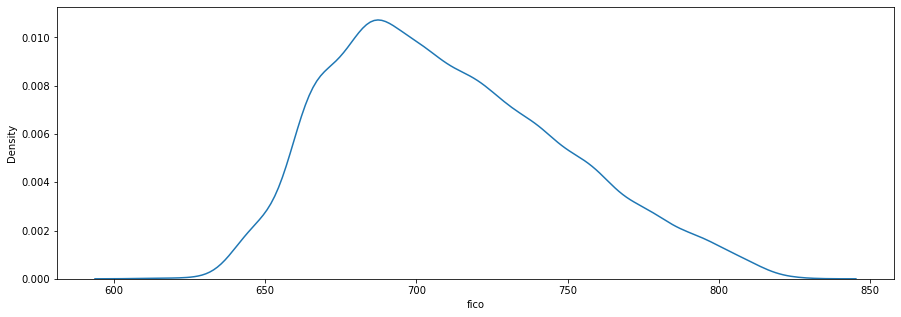

In [108]:
sns.kdeplot(df['fico'])


In [103]:
poorRatio = dfPoor.fico.count()/df.fico.count()
fairRatio = dfFair.fico.count()/df.fico.count()
goodRatio = dfGood.fico.count()/df.fico.count()
verygoodRatio = dfVeryGood.fico.count()/df.fico.count()
excellentRatio = dfExcellent.fico.count()/df.fico.count()
print(poorRatio*100, round(fairRatio*100,2), round(goodRatio*100,2), round(verygoodRatio*100,2), round(excellentRatio*100,2))
print(16,17,21,25,21)

0.0 14.0 62.72 21.77 1.51
16 17 21 25 21


In [68]:
yCreditScore = np.array(df["credit.policy"]).reshape(-1,1)
xIntRate = np.array(df['int.rate']).reshape(-1,1)
xIncome = np.array(df["Income"]).reshape(-1,1)
xRevolUtil = np.array(df['revol.util']).reshape(-1,1)
model = LinearRegression().fit(xIncome,yCreditScore)
print(model.score(xIncome,yCreditScore))
model = LinearRegression().fit(xIntRate,yCreditScore)
print(model.score(xIntRate,yCreditScore))
model = LinearRegression().fit(xRevolUtil,yCreditScore)
print(model.score(xRevolUtil,yCreditScore))

7.850646566487374e-05
0.0864883924018427
0.010835757689284353
